In [5]:
# imports important packages
import numpy as np
import pandas as pd
import scipy.stats as scs
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# Reading data
data = pd.read_csv('../Data/AdSmartABdata.csv')
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [26]:
def add_data_hour_col(test_data):
    
    try:
        test_data['hour'] = test_data['hour'].astype('str')
        test_data['date_hour'] = pd.to_datetime(test_data['date'] + " " + test_data['hour'] + ":00" + ":00")
        test_data['date_hour'] = test_data['date_hour'].map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
        return test_data
    except KeyError as e:
        print("key hour, or data missing")
        return test_data


def split_data(test_data):
    try:
        exposed = test_data[test_data['experiment'] == 'exposed']
        control = test_data[test_data['experiment'] == 'control']
        
        return exposed, control
    except KeyError as e:
        print("key experiment is missing")
        return test_data

def drop_no_responds(data):
    cleaned_data = data.query("not (yes == 0 & no == 0)")
    return cleaned_data

def get_engagemen_success_df(data):
    
    res = data.groupby('date_hour').agg({'yes': 'sum', 'no': 'count'})
    res = res.rename(columns={'no': 'engagement', 'yes': 'success'})
    return res

def bernouli_series(engagment_list, success_list):
    bernouli_s = []

    for e, s in zip(engagment_list, success_list) :
        no_list = (e - s) * [0]
        yes_list = (s) * [1]
        series_item = no_list + yes_list
        random.shuffle(series_item)
        bernouli_s += series_item
    return bernouli_s

In [24]:

def transform_data(df):
    cleaned_data = drop_no_responds(data)

    exposed, control = split_data(cleaned_data)
    exposed_with_datehour = add_data_hour_col(exposed)
    control_with_datehour = add_data_hour_col(control)


    exposed_engagement_success = get_engagemen_success_df(exposed_with_datehour)
    control_engagement_success = get_engagemen_success_df(control_with_datehour)

    exposed_bernouli =  bernouli_series(exposed_engagement_success['engagement'].to_list(),
                    exposed_engagement_success['success'].to_list())

    control_bernouli = bernouli_series(control_engagement_success['engagement'].to_list(),
                    control_engagement_success['success'].to_list())
    
    return np.array(exposed_bernouli), np.array(control_bernouli)

In [19]:
def conditionalSPRT(x,y,t1,alpha=0.05,beta=0.10,stop=None):
    
    if t1<=1:
        print('warning',"Odd ratio should exceed 1.")
    if (alpha >0.5) | (beta >0.5):
        print('warning',"Unrealistic values of alpha or beta were passed."
                 +" You should have good reason to use large alpha & beta values")
    if stop!=None:
        stop=math.floor(n0)

    def comb(n, k):
        return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

    def lchoose(b, j):
        a=[]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            if len(j)<2:
                j=j[0]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            for k in j:
                n=b
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)
        else:
            n=b
            k=j
            if (0 <= k) & (k<= n):
                a.append(math.log(comb(n,k)))
            else:
                a.append(0)

        return np.array(a)

    def g(x,r,n,t1,t0=1):
        return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

    def h(x,r,n,t=1):
     
        return f(r,n,t,offset=ftermlog(x,r,n,t))

    def f(r,n,t,offset=0):
        upper=max(0,r-n)
        lower=min(n,r)
        rng=list(range(upper,lower+1))
        return np.sum(fterm(rng,r,n,t,offset))

    def fterm(j,r,n,t,offset=0):
        ftlog=ftermlog(j,r,n,t,offset)
        return np.array([math.exp(ex) for ex in ftlog])

    def ftermlog(j,r,n,t,offset=0):
    
        xx=r-j
        lch=lchoose(n,j)
        lchdiff=lchoose(n,xx)
        lg=np.array(j)*math.log(t)
        lgsum=lch+lchdiff
        lgsum2=lgsum+lg
        lgdiff=lgsum2-offset

        return lgdiff

    def logf(r,n,t,offset=0):
     
        z=f(r,n,t,offset)
        if z>0:
            return math.log(z)
        else:
            return np.nan

    def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
     
        offset=ftermlog(math.ceil(r/2),r,n,t1c)
        z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
        a=-math.log(alpha/(1-beta))
        b=math.log(beta/(1-alpha))
        lower=b
        upper=1+a
        return (np.array([lower,upper])+z)/math.log(t1c/t0)

    l=math.log(beta/(1-alpha))
    u=-math.log(alpha/(1-beta))
    sample_size=min(len(x),len(y))
    n=np.array(range(1,sample_size+1))

    if stop!=None:
        n=np.array([z for z in n if z<=stop])
    x1=np.cumsum(x[n-1])
    r=x1+np.cumsum(y[n-1])
    stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g
     #
      # Perform the test by finding the first index, if any, at which `stats`
      # falls outside the open interval (l, u).
      #
    clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
    limits=[]
    for v in clu:
        inArray=[]
        for vin in v:
            inArray.append(math.floor(vin))
        limits.append(np.array(inArray))
    limits=np.array(limits)

    k=np.where((stats>=u) | (stats<=l))
    cvalues=stats[k]
    if cvalues.shape[0]<1:
        k= np.nan
        outcome='Unable to conclude.Needs more sample.'
    else:
        k=np.min(k)
        if stats[k]>=u:
            outcome=f'Exposed group produced a statistically significant increase.'
        else:
            outcome='Their is no statistically significant difference between two test groups'
    if (stop!=None) & (k==np.nan):
      #
      # Truncate at trial stop, using Meeker's H0-conservative formula (2.2).
      # Leave k=NA to indicate the decision was made due to truncation.
      #
        c1=clowerUpper(r,stop,t1,alpha,beta)
        c1=math.floor(np.mean(c1)-0.5)
        if x1[n0]<=c1:
            truncate_decision='h0'
            outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
        else:
            truncate_decision='h1'
            outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
        truncated=stop
    else:
        truncate_decision='Non'
        truncated=np.nan
    return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

In [21]:
class ConditionalSPRT:
     
    def __init__(self, x, y, odd_ratio, alpha=0.05, beta=0.10, stop=None):
        self.x = x
        self.y = y
        self.odd_ratio = odd_ratio
        self.alpha = alpha
        self.beta = beta
        self.stop = stop
   
    def run(self):
        res = conditionalSPRT(self.x, self.y, self.odd_ratio,
                              self.alpha, self.beta,
                              self.stop)
        return res
    def resJson(self, res):
        outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits = res
        jsonRes = {
            "name": "Sequential AB testing",
            "outcome": outcome,
            "decsionMadeIndex": k,
            "numberOfObservation": len(n),
            "truncated": truncated,
            "truncateDecision": truncate_decision,        
      
        }
        return jsonRes
    
    def plotExperiment(self, res):
        outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits = res
        lower = limits[:, 0]
        upper = limits[:,1]

        fig, ax = plt.subplots(figsize=(12,7))

        ax.plot(n, x1, label='Cumlative value of yes+no')

        ax.plot(n, lower, label='Lower Bound', linestyle='--')
        ax.plot(n, upper, label='Upper Bound', linestyle='--')

        plt.legend()


        plt.show()

In [27]:
# giving parameter to the class
alpha = 0.5
beta = 0.10
exposed,  control = transform_data(data)
odd_ratio = 1.01

conditionalSPRTObj = ConditionalSPRT(exposed, control, odd_ratio, alpha, beta)
res = conditionalSPRTObj.run()


ipykernel_launcher:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:

print(conditionalSPRTObj.resJson(res))

{'name': 'Sequential AB testing', 'outcome': 'Unable to conclude.Needs more sample.', 'decsionMadeIndex': nan, 'numberOfObservation': 586, 'truncated': nan, 'truncateDecision': 'Non'}


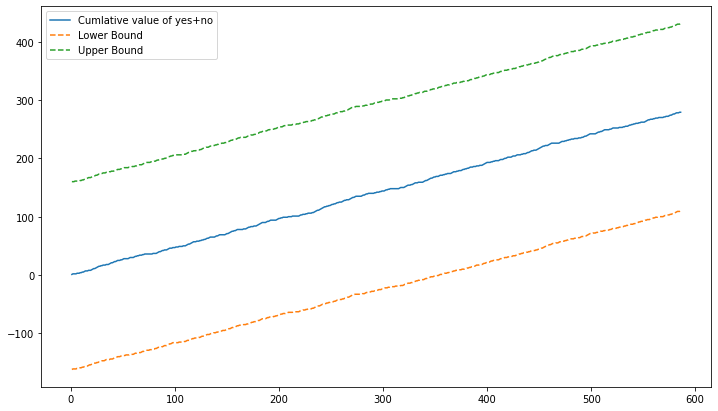

In [29]:
conditionalSPRTObj.plotExperiment(res)

Based on the result we can conclude that the number of sample is very small,we need more sample to reject either of the hypothesis.